In [ ]:
!pip install kaggle

In [ ]:
import json
kaggle_credentials = json.load(open("kaggle.json"))


In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = kaggle_credentials['username']
os.environ['KAGGLE_KEY'] = kaggle_credentials['key']

In [ ]:
!kaggle datasets download -d abdallahalidev/plantvillage-dataset

Dataset URL: https://www.kaggle.com/datasets/abdallahalidev/plantvillage-dataset
License(s): CC-BY-NC-SA-4.0
100% 2.03G/2.04G [00:16<00:00, 105MB/s] 
100% 2.04G/2.04G [00:16<00:00, 131MB/s]


In [ ]:
import zipfile

with zipfile.ZipFile('/content/plantvillage-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall()


In [ ]:
# Number of files in /content/Apple/Apple___Apple_scab: 630
# Number of files in /content/Apple/Apple___Black_rot: 621
# Number of files in /content/Apple/Apple___Cedar_apple_rust: 275
# Number of files in /content/Apple/Apple___healthy: 1645
import os
import random

# Define the dataset directory and the target number of images per class
dataset_dir = "/content/Apple"
target_size = 275  # You can adjust this based on the minimum class size

# For each class (directory), randomly remove excess images
for class_dir in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_dir)

    if os.path.isdir(class_path):
        images = os.listdir(class_path)

        # If the class has more than 275 images, randomly remove the excess
        if len(images) > target_size:
            images_to_remove = random.sample(images, len(images) - target_size)

            for image in images_to_remove:
                os.remove(os.path.join(class_path, image))

            print(f"Removed {len(images_to_remove)} images from class {class_dir}")

print("Dataset balanced to 275 images per class!")





Removed 355 images from class Apple___Apple_scab
Removed 1370 images from class Apple___healthy
Removed 346 images from class Apple___Black_rot
Dataset balanced to 275 images per class!


In [ ]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras
from keras.callbacks import EarlyStopping,ModelCheckpoint
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tqdm import tqdm


In [ ]:
def data(dataset_path):
    images = []
    labels = []
    for subfolder in tqdm(os.listdir(dataset_path)):
        subfolder_path = os.path.join(dataset_path, subfolder)
        for image_filename in os.listdir(subfolder_path):
            image_path = os.path.join(subfolder_path, image_filename)
            images.append(image_path)
            labels.append(subfolder)
    df = pd.DataFrame({'image': images, 'label': labels})
    return df


train = data('/content/Apple')
train.head()


X_train, X_test1, y_train, y_test1 = train_test_split(train['image'], train['label'], test_size=0.2, random_state=42,shuffle=True,stratify=train['label'])
X_val, X_test, y_val, y_test = train_test_split(X_test1,y_test1, test_size=0.5, random_state=42,shuffle=True,stratify=y_test1)
df_train = pd.DataFrame({'image': X_train, 'label': y_train})
df_test = pd.DataFrame({'image': X_test, 'label': y_test})
df_val = pd.DataFrame({'image': X_val, 'label': y_val})


100%|██████████| 4/4 [00:00<00:00, 1347.57it/s]


In [ ]:
image_size = (256,256)
batch_size = 32
datagen = ImageDataGenerator(
    rescale=1./255
)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    #rotation_range=20,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #shear_range=0.2,
    #zoom_range=0.2,
    horizontal_flip=True,
    #fill_mode='nearest'
)
train_generator = train_datagen.flow_from_dataframe(
    df_train,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    shuffle=True
)
test_generator = datagen.flow_from_dataframe(
    df_test,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    shuffle=False
)
val_generator = datagen.flow_from_dataframe(
    df_val,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    shuffle=False
)


Found 880 validated image filenames belonging to 4 classes.
Found 110 validated image filenames belonging to 4 classes.
Found 110 validated image filenames belonging to 4 classes.


In [ ]:
class_ = test_generator.class_indices.keys()
class_ = list(class_)

class_

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy']

In [ ]:
model = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size = (3,3), activation = 'relu', input_shape = (224,224,3)),
    keras.layers.MaxPooling2D(2,2),

    keras.layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    keras.layers.MaxPooling2D(2,2),

    keras.layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    keras.layers.MaxPooling2D(2,2),

    keras.layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    keras.layers.MaxPooling2D(2,2),

    keras.layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    keras.layers.MaxPooling2D(2,2),

    keras.layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    keras.layers.MaxPooling2D(2,2),

    keras.layers.Flatten(),

    keras.layers.Dense(64, activation='relu'),

    keras.layers.Dense(4, activation='sigmoid'),

])
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_48 (Conv2D)                   │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_48 (MaxPooling2D)      │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_49 (Conv2D)                   │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_49 (MaxPooling2D)      │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_50 (Conv2D)                   │ (None, 60, 60, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_50 (MaxPooling2D)      │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_51 (Conv2D)                   │ (None, 28, 28, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_51 (MaxPooling2D)      │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_52 (Conv2D)                   │ (None, 12, 12, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_52 (MaxPooling2D)      │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_53 (Conv2D)                   │ (None, 4, 4, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_53 (MaxPooling2D)      │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,812 (718.02 KB)

 Trainable params: 183,812 (718.02 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
checkpoint_cb =ModelCheckpoint("my_keras_model.keras", save_best_only=True)
early_stopping_cb =EarlyStopping(patience=5, restore_best_weights=True)
model.compile(optimizer ='adam', loss='categorical_crossentropy', metrics=['accuracy',keras.metrics.AUC()])
hist=model.fit(train_generator,epochs=10,validation_data=val_generator,callbacks=[checkpoint_cb,early_stopping_cb])


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


28/28 ━━━━━━━━━━━━━━━━━━━━ 19s 448ms/step - accuracy: 0.2963 - auc_7: 0.5427 - loss: 1.3739 - val_accuracy: 0.4818 - val_auc_7: 0.7262 - val_loss: 1.1946
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - accuracy: 0.5510 - auc_7: 0.7728 - loss: 1.0319 - val_accuracy: 0.6182 - val_auc_7: 0.8207 - val_loss: 0.9245
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.6663 - auc_7: 0.8527 - loss: 0.8218 - val_accuracy: 0.7364 - val_auc_7: 0.8968 - val_loss: 0.7512
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.7455 - auc_7: 0.9130 - loss: 0.6619 - val_accuracy: 0.7455 - val_auc_7: 0.9233 - val_loss: 0.6065
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.8046 - auc_7: 0.9296 - loss: 0.5696 - val_accuracy: 0.8000 - val_auc_7: 0.9447 - val_loss: 0.5168
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.8413 - auc_7: 0.9439 - loss: 0.4951 - val_accuracy: 0.7727 - val_auc_7: 0.9318 - val_loss: 0.5601
Epoch 7/10
28/28 ━━━━━━━━━━━━━━

In [ ]:
print(class_)

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy']


In [ ]:
score, acc,auc = model.evaluate(test_generator)
print('Test Loss =', score)
print('Test Accuracy =', acc)
print('Test AUC =', auc)

hist_=pd.DataFrame(hist.history)
hist_



4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8351 - auc_7: 0.9608 - loss: 0.3694
Test Loss = 0.41140103340148926
Test Accuracy = 0.8272727131843567
Test AUC = 0.9551790356636047


,accuracy,auc_7,loss,val_accuracy,val_auc_7,val_loss
0,0.348864,0.619575,1.327706,0.481818,0.726185,1.194552
1,0.567045,0.786207,0.987829,0.618182,0.820689,0.924515
2,0.722727,0.890175,0.716906,0.736364,0.896777,0.751215
3,0.772727,0.922909,0.605143,0.745455,0.923320,0.606457
4,0.793182,0.926725,0.585827,0.800000,0.944656,0.516789
5,0.829545,0.941873,0.511410,0.772727,0.931804,0.560087
6,0.851136,0.953525,0.428298,0.836364,0.955579,0.410182
7,0.859091,0.958975,0.386067,0.836364,0.951446,0.451429
8,0.834091,0.948950,0.460579,0.818182,0.939105,0.454398
9,0.861364,0.952658,0.404080,0.845455,0.948829,0.484912


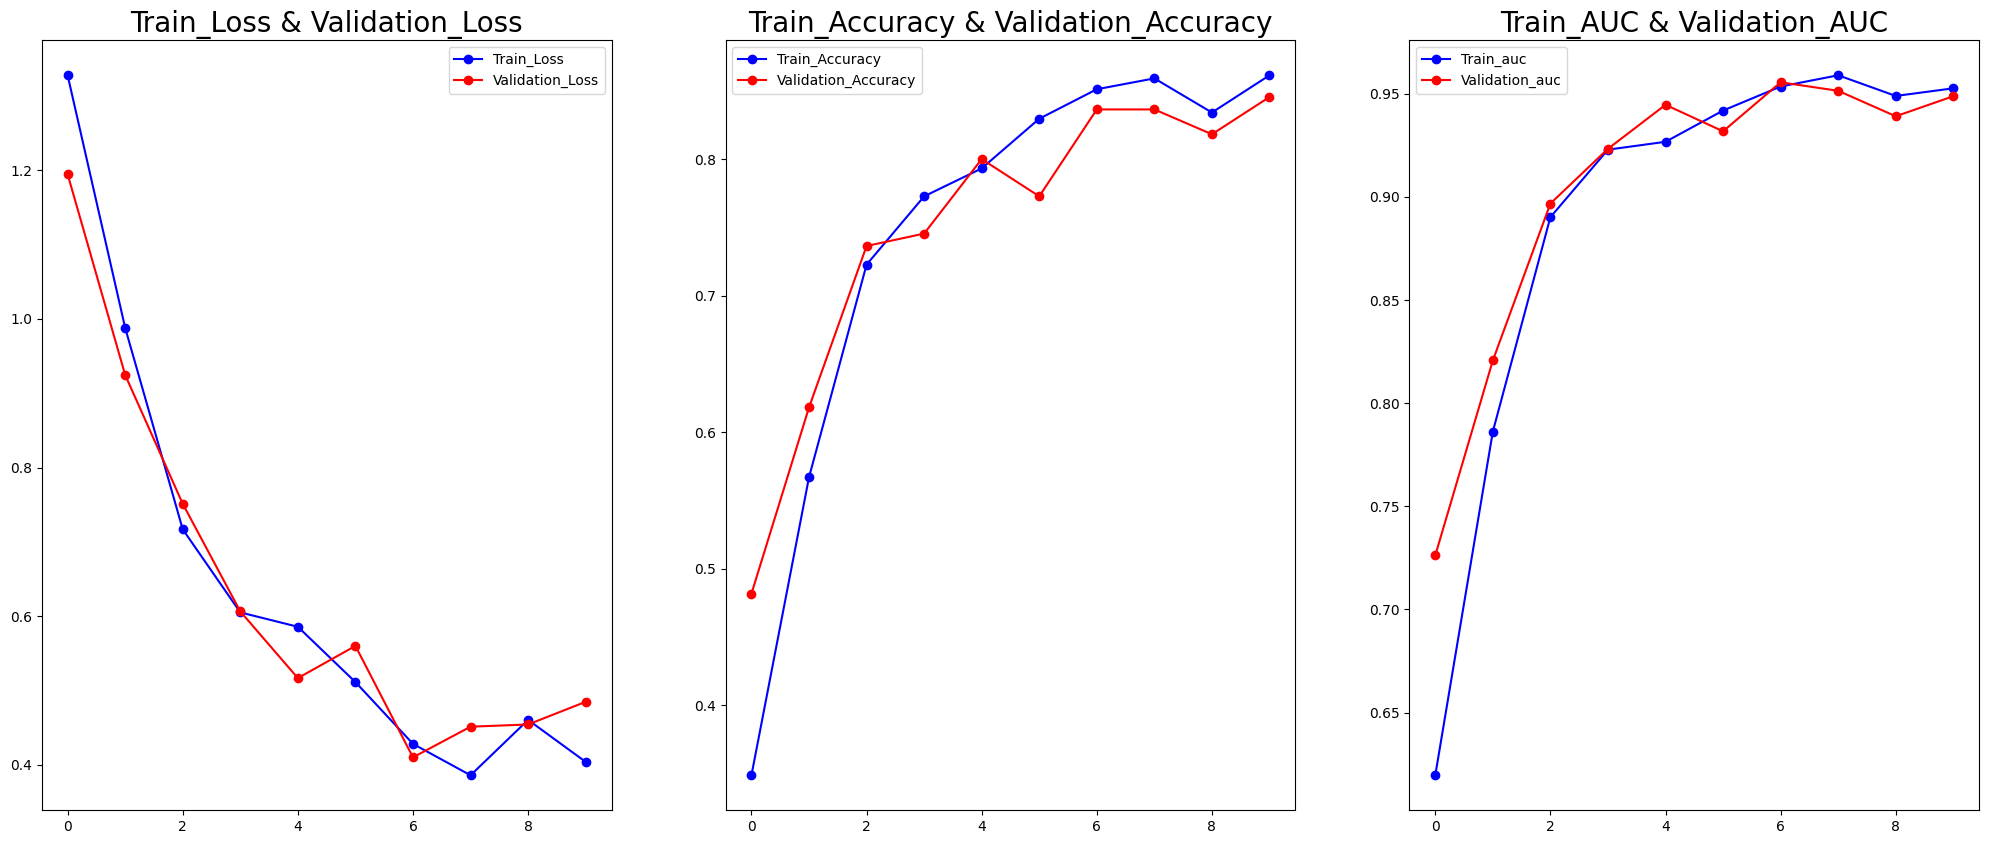

In [ ]:
plt.figure(figsize=(25,10))
plt.subplot(1,3,1)
plt.plot(hist_['loss'],'b-o',label='Train_Loss')
plt.plot(hist_['val_loss'],'r-o',label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,3,2)
plt.plot(hist_['accuracy'],'b-o',label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],'r-o',label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()
plt.subplot(1,3,3)
plt.plot(hist_.iloc[:,1],'b-o',label='Train_auc')
plt.plot(hist_.iloc[:,4],'r-o',label='Validation_auc')
plt.title('Train_AUC & Validation_AUC',fontsize=20)
plt.legend()
plt.show()


In [ ]:
# Get true labels
y_test = test_generator.classes
# Predict probabilities for each class
predictions = model.predict(test_generator)
# Convert predicted probabilities to class labels (choose the class with the highest probability)
y_pred = np.argmax(predictions, axis=1)
# Flatten both arrays just in case
y_test = np.ravel(y_test)
y_pred = np.ravel(y_pred)
# Create a DataFrame to compare actual vs predicted labels
df = pd.DataFrame({'Actual': y_test, 'Prediction': y_pred})
# Display the DataFrame
df.head()  # Show the first few rows of the comparison


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step


,Actual,Prediction
0,3,3
1,3,3
2,1,1
3,2,2
4,0,0


In [ ]:
ClassificationReport = classification_report(y_test,y_pred,target_names=class_)
print('Classification Report is : ', ClassificationReport)


Classification Report is :                            precision    recall  f1-score   support

      Apple___Apple_scab       0.81      0.75      0.78        28
       Apple___Black_rot       0.79      0.81      0.80        27
Apple___Cedar_apple_rust       0.93      0.96      0.95        28
         Apple___healthy       0.78      0.78      0.78        27

                accuracy                           0.83       110
               macro avg       0.83      0.83      0.83       110
            weighted avg       0.83      0.83      0.83       110



In [ ]:
model.save('apple.h5')

In [ ]:
!pip install tensorFlowjs


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 85.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 103.7 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.1
    Uninstalling packaging-24.1:
      Successfully uninstalled packaging-24.1


In [ ]:
!tensorflowjs_converter --input_format keras /content/apple.h5 /content/apple.js


2024-10-12 12:39:38.261724: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-12 12:39:38.282745: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-12 12:39:38.289075: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-12 12:39:39.689962: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
failed to lookup keras version from the file,
    this is likely a weight only file


In [ ]:
from PIL import Image
image_path='/content/test2.jpeg'
image = Image.open(image_path)

# Resize the image to match the model's input shape (224, 224)
image = image.resize((256,256))  # Update to 224x224
image = np.array(image)
 # Convert to numpy array

# If the model expects a specific number of channels, ensure it's RGB
# if image.shape[-1] == 3:  # If it's an RGB image
#     image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)  # Change RGB to BGR if necessary

# Normalize the image
image = image / 255.0  # Change based on your model's requirements

# Expand dimensions to match model input shape (1, 224, 224, 3)
image = np.expand_dims(image, axis=0)  # Add batch dimension



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step
[[9.8479444e-01 9.7881854e-01 4.7745347e-05 9.9717891e-01]]


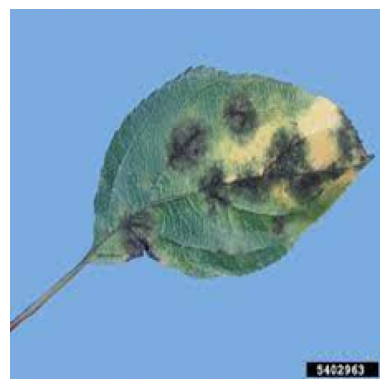

Predicted class: Apple___healthy


In [ ]:
predictions = model.predict(image)
print(predictions)

# Step 6: Display the image and predictions
import matplotlib.pyplot as plt

plt.imshow(image.squeeze(), cmap='gray')
plt.axis('off')
plt.show()

predicted_class = np.argmax(predictions)
print("Predicted class:", class_[predicted_class])


In [ ]:
# ['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Target_Spot', 'Tomato___healthy']

